In [1]:
import os
import gzip
import shutil
import numpy as np
from mlxtend.data import loadlocal_mnist
from keras.layers import Flatten, Input, Conv2D, Lambda, Reshape, Concatenate, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras import Model
from keras.optimizers import Adam
from sklearn.feature_extraction.image import extract_patches_2d
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.
C:\Users\dibya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dibya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dibya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dibya\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
data_source = "D:/Research Datasets/Character Recognition Dataset/MNIST Digit/Train"
data_temp = "D:/Temp_data/MNIST/Train"
data_store = "D:/Temp_store/MNIST/Train"

In [3]:
c_list = os.listdir(data_source)
print(c_list)

['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz']


In [4]:
if os.path.isdir(data_temp):
    shutil.rmtree(data_temp)
    os.makedirs(data_temp)
else:
    os.makedirs(data_temp)

In [5]:
if os.path.isdir(data_store):
    shutil.rmtree(data_store)
    os.makedirs(data_store)
else:
    os.makedirs(data_store)

In [6]:
for c_l in c_list:
    with gzip.open(data_source+'/'+c_l, 'rb') as f_in:
        with open(data_temp+'/'+c_l[:(c_l.find('.gz'))], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [7]:
c_list = os.listdir(data_temp)
print(c_list)

['train-images-idx3-ubyte', 'train-labels-idx1-ubyte']


In [8]:
train_image, train_label = loadlocal_mnist(images_path=data_temp+'/'+'train-images-idx3-ubyte', labels_path=data_temp+'/'+'train-labels-idx1-ubyte')

In [9]:
train_image=np.expand_dims(train_image, axis=2)
train_image = np.reshape(train_image, (-1,28,28))
train_image=np.expand_dims(train_image, axis=3)
print(train_image.shape)

(60000, 28, 28, 1)


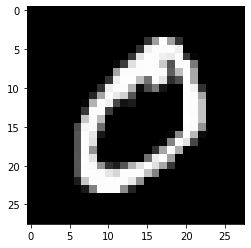

In [10]:
plt.imshow(train_image[1,:,:,0],cmap='gray')
plt.imsave("b_0.jpg", train_image[1,:,:,0],cmap="gray")

In [11]:
patch_size = [5,5]
opt = Adam()

In [12]:
def new_model(inp_size):
    inp = Input(shape=(inp_size[0],inp_size[1],inp_size[2]))
    x = Conv2D(10,5,strides=(1, 1),padding="same", use_bias=False,name='conv1')(inp)
    x = Activation('sigmoid')(x)
    x = MaxPooling2D(pool_size=(2, 2),name='MaxPool1')(x)
    x = Conv2D(10,5,strides=(1, 1),padding="same", use_bias=False,name='conv2')(x)
    x = Activation('sigmoid')(x)
    x = MaxPooling2D(pool_size=(2, 2),name='MaxPool2')(x)
    x = Flatten(name='flat')(x)
    x = Dense(20, activation='sigmoid', use_bias=False,name='Fc1')(x)
    x = Dense(10,activation='softmax', use_bias=False,name='Fc2')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'mse'])
    return model

model = new_model([28,28,1])
w = model.get_weights()

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 10)        250       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 10)        0         
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 10)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 10)        2500      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 10)        0         
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 7, 7, 10)          0   

In [14]:
def get_some_image_per_class(train_image, train_label,count):
    c = np.zeros((1,10))[0]
    for i in range(train_image.shape[0]):
        if c[train_label[i]] < count:
            if np.sum(c) == 0:
                new_train  = np.expand_dims(train_image[i,:,:,:],axis=0)
                new_label = np.expand_dims(train_label[i],axis=0)
            else:
                new_train = np.append(new_train,np.expand_dims(train_image[i,:,:,:],axis=0), axis=0)
                new_label = np.append(new_label, np.expand_dims(train_label[i],axis=0), axis=0)
            c[train_label[i]] = c[train_label[i]]+1
    return new_train, new_label

In [15]:
def patches_extract(img,patch_size):
    patches = extract_patches_2d(img,(patch_size[0],patch_size[1]))
    patches = np.reshape(patches,(-1,patch_size[0]*patch_size[1]*img.shape[2]))
    patches = patches[np.var(patches,axis=1)!=0,:]
    return patches

In [16]:
def get_new_weights_BFELM(temp_data,temp_label,w_t):
    out_weight = np.random.random((w_t.shape[-1],temp_label.shape[-1]))
    H = np.matmul(temp_label,np.linalg.pinv(out_weight))
    H = H + np.random.random(H.shape)
    w_new = np.matmul(np.linalg.pinv(temp_data),H)
    u, s, v = np.linalg.svd(w_new, full_matrices=True)
    if w_new.shape[0]>w_new.shape[1]:
        w_new = u[:,0:w_new.shape[1]]
    else:
        w_new = v[0:w_new.shape[0],:]
    w_new = np.reshape(w_new,w_t.shape)
    return w_new

In [17]:
new_train, new_label = get_some_image_per_class(train_image, train_label,20)

In [18]:
for i in range(new_train.shape[0]):
    patches = patches_extract(new_train[i,:,:,:],patch_size)
    if i == 0:
        temp_data = patches
        temp_label = np.repeat(new_label[i],patches.shape[0])
    else:
        temp_data = np.append(temp_data, patches, axis=0)
        temp_label = np.append(temp_label, np.repeat(new_label[i],patches.shape[0]),axis=0)
onehot_encoder = OneHotEncoder(sparse=False)
temp_label = onehot_encoder.fit_transform(np.expand_dims(temp_label,axis=1))
print(temp_data.shape)
print(temp_label.shape)

(66249, 25)
(66249, 10)


In [19]:
w[0] = get_new_weights_BFELM(temp_data,temp_label,w[0])
model.set_weights(w)

In [20]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer("MaxPool1").output)
new_train = intermediate_layer_model.predict(new_train)

In [21]:
print(new_train.shape)

(200, 14, 14, 10)


AxesSubplot(0.285345,0.536818;0.133621x0.343182)


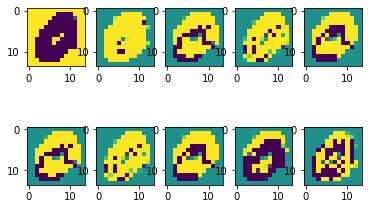

In [22]:
fig, axs = plt.subplots(2,5)
print(axs[0,1])
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(new_train[1,:,:,2*i+j])
        plt.imsave("b_0_conv_1"+str(5*i+j)+".jpg", new_train[1,:,:,5*i+j])

In [23]:
for i in range(new_train.shape[0]):
    patches = patches_extract(new_train[i,:,:,:],patch_size)
    if i == 0:
        temp_data = patches
        temp_label = np.repeat(new_label[i],patches.shape[0])
    else:
        temp_data = np.append(temp_data, patches, axis=0)
        temp_label = np.append(temp_label, np.repeat(new_label[i],patches.shape[0]),axis=0)
onehot_encoder = OneHotEncoder(sparse=False)
temp_label = onehot_encoder.fit_transform(np.expand_dims(temp_label,axis=1))
print(temp_data.shape)
print(temp_label.shape)

(19821, 250)
(19821, 10)


In [24]:
w[1] = get_new_weights_BFELM(temp_data,temp_label,w[1])
model.set_weights(w)

In [25]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer("MaxPool2").output)
new_train_t = intermediate_layer_model.predict(train_image)

In [26]:
print(new_train_t.shape)

(60000, 7, 7, 10)


AxesSubplot(0.285345,0.536818;0.133621x0.343182)


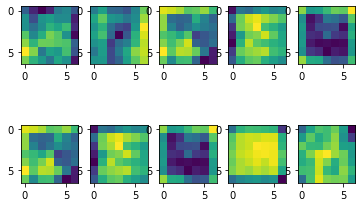

In [27]:
fig, axs = plt.subplots(2,5)
print(axs[0,1])
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(new_train_t[1,:,:,2*i+j])
        plt.imsave("b_0_conv_2"+str(5*i+j)+".jpg", new_train_t[1,:,:,5*i+j])

In [28]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer("flat").output)
temp_data = intermediate_layer_model.predict(train_image)
onehot_encoder = OneHotEncoder(sparse=False)
temp_label = onehot_encoder.fit_transform(np.expand_dims(train_label,axis=1))
print(temp_data.shape)
print(temp_label.shape)

(60000, 490)
(60000, 10)


In [29]:
w[2] = get_new_weights_BFELM(temp_data,temp_label,w[2])
model.set_weights(w)

In [30]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer("Fc1").output)
temp_data = intermediate_layer_model.predict(train_image)
onehot_encoder = OneHotEncoder(sparse=False)
temp_label = onehot_encoder.fit_transform(np.expand_dims(train_label,axis=1))
print(temp_data.shape)
print(temp_label.shape)

(60000, 20)
(60000, 10)


In [31]:
w[3]=np.matmul(np.linalg.pinv(temp_data),temp_label)

In [32]:
model.set_weights(w)

In [33]:
model.evaluate(train_image,temp_label)

60000/60000 [==============================] - 8s 134us/step


[1.7415810564676921, 0.9237499833106995, 0.07519658654928207]

In [34]:
data_source = "D:/Research Datasets/Character Recognition Dataset/MNIST Digit/Test"
data_temp = "D:/Temp_data/MNIST/Test"
data_store = "D:/Temp_store/MNIST/Test"

In [35]:
c_list = os.listdir(data_source)
print(c_list)

['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']


In [36]:
if os.path.isdir(data_temp):
    shutil.rmtree(data_temp)
    os.makedirs(data_temp)
else:
    os.makedirs(data_temp)

In [37]:
if os.path.isdir(data_store):
    shutil.rmtree(data_store)
    os.makedirs(data_store)
else:
    os.makedirs(data_store)

In [38]:
for c_l in c_list:
    with gzip.open(data_source+'/'+c_l, 'rb') as f_in:
        with open(data_temp+'/'+c_l[:(c_l.find('.gz'))], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [39]:
c_list = os.listdir(data_temp)
print(c_list)

['t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte']


In [40]:
test_image, test_label = loadlocal_mnist(images_path=data_temp+'/'+'t10k-images-idx3-ubyte', labels_path=data_temp+'/'+'t10k-labels-idx1-ubyte')

In [41]:
test_image=np.expand_dims(test_image, axis=2)
test_image = np.reshape(test_image, (-1,28,28))
test_image=np.expand_dims(test_image, axis=3)
print(test_image.shape)

(10000, 28, 28, 1)


In [42]:
onehot_encoder = OneHotEncoder(sparse=False)
test_label = onehot_encoder.fit_transform(np.expand_dims(test_label,axis=1))

In [43]:
import time

In [44]:
start = time.time()
print(model.evaluate(test_image,test_label))
end = time.time()
print(f"Runtime of the testing is {end - start}")

10000/10000 [==============================] - 1s 123us/step
[1.7355779582977295, 0.9262999892234802, 0.07501350343227386]
Runtime of the testing is 1.2372276782989502


In [45]:
1.19053316116333/10000

0.00011905331611633301